# Chapter 8: Dimensionality Reduction

- Reducing dimensionality causes some information to be lost but can speed up training
- Reducing dimensionality can be useful for data visualization

# 1. The Curse of Dimensionality

In high dimension, there is plently of space. This means that two points can be very far apart even though they both lie within the same unit hypercube.
- High dimensional datasets are at risk of being very sparse. Most training instances are likely to be far away from each other.
- This means that new instance will likely be far away from any training instance, making predictions less reliable than in lower dimensions.
- As a result, more dimensions the training set has, the greater the risk of overfitting it

![cod](images/curse_of_dimensionality.jpg)

https://www.youtube.com/watch?v=DyxQUHz4jWg

![cod](images/cod.png)

# 2. Main Approaches for Dimensionality Reduction

## 2.1 Projection

Training instances are not spread out uniformly. Features sometimes are highly corelated. As a result, all training instances lie within a much lower-dimensional subspace of the high-dimensional space. i.e, there exist a lower dimensional subspace inside the higher dimensional subspace

![figure8.2](images/figure8.2.png)

All training instances in the above image lie close to a plane. This is the lower-dimensional (2D) subspace of the higher-dimensional (3D)

![figure8.3](images/figure8.3.png)

If we project every training instances perpendicularly onto this subspace, we get the new 2D dataset as shown above.

## 2.2 Manifold Learning

Project may not always be the best approach to dimensionality reduction as there are cases where the subspace may twist and turn (swiss roll)

![figure8.4](images/figure8.4.png)

If we project the subspace onto a plane, we would squash the different layers of the swiss roll together which is not what we want.

![figure8.5](images/figure8.5.png)

The swiss role is an example of a 2D manifold.  
- A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space.
- More generally, a d-dimensional manifold is a part of an n-dimensional space (d < n) that locally resembles a d dimensional hyperplane. 
- For the swiss role example, d=2 and n=3.

**Manifold Learning**: Modeling the manifold on which the training instances lie.
- Relies on the manifold assumption/hypothesis which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold.

# 3. Algorithms

## 3.1 Principal Component Analysis (PCA)

- First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

### 3.1.1 How do we choose the hyperplane?

![figure8.7](images/figure8.7.png)

- For example, a simple 2D dataset is represented on the left, along with three different 1D axes.
- On the right is the result of the projection of the dataset onto each of these axes.
- The projection onto the solid line preseves the maximum variance as compared to the other 2 lines
- As such, it is reasonable to select the axis that **preserves the maximum amount of variance** as it will most likely lose less information than the other projections.
- It is also the axis that **minimizes the mean squared distance** between the original dataset and its projection onto that axis.

### 3.1.2 Principal Components (PC)

- PCA identifies the axis that accounts for the largest amount of variance in the training set. (c1)
- It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. (c2)
- For higher-dimensional data, PCA would also find the third axis, orthogonal to the previous axes and a fourth, fifth so on.
- The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data
- For each PC, PCA finds a zero-centered unit vector pointing in the direction of the PC.
- PCA assumes that the dataset is centered around the origin. Scikit-Learn's PCA classes take care of centering the data for us.

### 3.1.3 How to find the PCs of a training set?

Using a matrix factorization technique called Singular Value Decomposition (SVD).
- SVD can decompose the training set matrix X into the matrix multiplication of three matrices $U \sum V^{T}$ where $V$ contains the unit vectors that define all the PCs that we are looking for.

![v](images/v.png)

In [4]:
import numpy as np
m = 200

X = np.random.randn(m, 2) / 10
X_centered = X - X.mean(axis=0) # centering
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]


Once identified all the PCs, we can reduce dimension to d dimensions by projecting it onto the hyperplane defined by the first d principal components. 

To obtain a reduced dataset $X_{d-proj}$ of dimensionality d, we multiple the training set matrix $X$ by the matrix $W_{d}$ which is the matrix containing first *d* columns of $V$    

![equation8.2](images/equation8.2.png)

In [5]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

### 3.1.4 How many PCs to use?

In [7]:
pca.explained_variance_ratio_

array([0.54259486, 0.45740514])

51% of the dataset's variance lies along the first PC and 48% lies along the second PC.

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [9]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

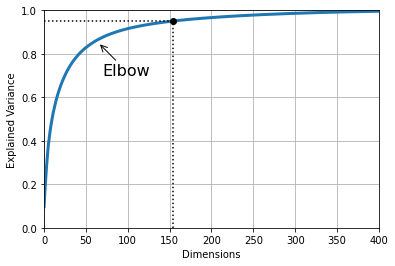

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [12]:
d

154

In [13]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [14]:
pca.n_components_

154

In [15]:
np.sum(pca.explained_variance_ratio_)

0.9504357295276175

### 3.1.5 PCA for Commpression

- By reducing dimension from 784 to just over 150 features, while most of the variance is preserved, the dataset is not less than 20% of the original size and this is a resonable compression ratio.
- We can also decompress the dataset back to 784 dimensions by applying inverse transformation of the PCA projection but we wont get back the original dataset since the projection lost a bit of information. But it will likely still be close to the original data.

In [16]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

![equation8.3](images/equation8.3.png)

### 3.1.6 Randomized PCA

- If we set `svd_solver` hyperparameter to `"randomized"`, Scikit-Learn uses a Randomized PCA, which is a stochastic algorithm that quickly finds an approximation of the first *d* PCs.
- SVD approach - computational complexity is $O(m $ x $n^{2})$ + $O(n^{3})$ (Much faster)
- Randomized PCA approach - computational complexity is $O(m $ x $d^{2})$ + $O(d^{3})$
- If *m* or *n* is greater than 500 and *d* < 80% of *m* or *n*, Scikit-Learn automatically uses randomized PCA. Else, it will use the SVD approach. 
- To force Scikit-Learn to use full SVD, set `svd_solver` hyperparameter to "full".

In [18]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

### 3.1.7 Incremental PCA

- Preceding implementations of PCA require the whole training set to fit in memory in order for the algorithm to run. 
- Incremental PCA (IPCA) allow us to aplit the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.
- This is useful for large training sets.

In [19]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

We could also use NumPy's `memmap` class, which allows us to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory when it needs it.

In [ ]:
filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

### 3.1.8 Kernel PCA

**Kernel Trick**: A mathematical technique that implicitly maps instances into a very high-dimensional space (called feature space), enabling non-linear classification and regression with Support Vector Machines.

Similarly for PCA, it is possible to perform complex nonlinear projections for dimensionality reduction.
- It is good at preserving clusters of instances after projection.
- Can unroll datasets that lie close to a twisted manifold

In [27]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [28]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### 3.1.9 Selecting a Kernel and Tuning Hyperparameters

Combine with supervised learning task

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [33]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Another way to evaluate is to select the kernel and hyperparameters that yield the lowest reconstruction error. While is is not possible to compute the reconstructed point, it is possible to find a point in the original space that would map close to the reconstructed point. This point is called the reconstruction pre-image. Once we have this pre-image, we can measure its squared distance to the original instance. We then select the kernel and hyperparameters that minimize this reconstruction pre-image error

In [34]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [35]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576613

## 3.2 Locally Linear Embedding (LLE)

- Another powerful nonlinear dimensionality reduction (NLDR) technique.
-  It is a Manifold Learning technique that does not rely on projections.
- LLE works by first measuring how each training instance linearly relates to its closed neighbours and then look for a low-dimensional representation of the training set where these local relationships are best preserved.
- This approach is good at unrolling twisted manifolds especially when there is not too much noise.

In [37]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

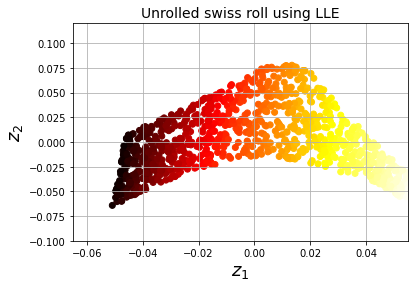

In [38]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

## 3.3 Multidimensional Scaling (MDS)

- Reduces dimensionality while trying to preserve the distances between the instances

In [39]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

## 3.4 Isomap

- Creates a graph by connecting each instance to its nearest neighbours.
- Then reduces dimensionality while trying to preserve the geodesic distances between the instances.
- The geodesic distance between two nodes in a graph is the number of nodes on the shortest path between these nodes

In [40]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

## 3.5 t-Distributed Neighbour Embedding (t-SNE)

- Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.
- Mostly used for visualization in particular to visualize clusters of instances in high-dimensional space.

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

c:\Users\joann\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\joann\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## 3.6 Linear Discriminant Analysis (LDA)

- A classification algorithm but during training it learns the most discriminative axes between the classes and these axes can be used to define a hyperplane onto which to project the data.
- The benefit of this approach is that the projection will keep classes as far apart as possible. 
- Hence LDA is a good technique to reduce dimensionality before running another classification algorithm suhc as SVM classifier

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

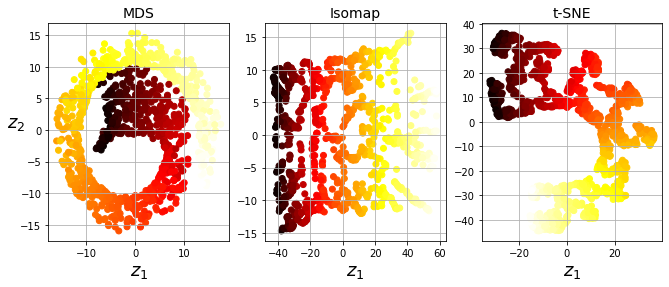

In [43]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# Exercises

**1. What are the main motivations for reducing a dataset's dimensionality? What are the drawbacks?**

Motivations are
- Speed up training algorithm (in some cases removing noise and redundant features, making training algorithm perform better)
- Visualize data and gain insights on most important features
- Save space (compression)

Drawbacks are
- Some information is lost
- Can be computationally intensive
- Adds some complexity to your Machine Learning pipelines
- Transformed features are hard to interpret

**2. What is the curse of dimensionality?**

- Refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space.
- Randomly sampled high-dimensional vectors are generally very sparse, increasing the risk of overfitting and making it very difficult to identify patterns in the data without having plenty of training data.

**3. Once a dataset's dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?**

- Almost always impossible to perfectly reverse the operation because some information gets lost during the dimensionality reduction.
- Some algorithms such as PCA have a simple reverse transformation procedure that can reconstruct a dataset relatively similar to original while other algorithms such as t-SNE do not.

**4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?**

- Can be used to significantly reduce the dimensionality of more datasets beacuse it can at least get rid of useless dimensions. 
- If there are not useless dimensions (swiss role dataset), then reducing dimensionality with PCA will lose too much information.

**5. Suppose you perform PCA on a 1000 dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?**

- Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset's intrinsic dimensionality.

**6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?**

- Regular PCA: Default but only works if dataset fits memory.
- Incremental PCA: useful for large datasets that don't fit in memory. But is slower than regular PCA.
- Randomized PCA: useful when you want to considerably reduce dimensionality and dataset fits in memory. Much faster than regular PCA.
- Kernel PCA: useful for nonlinear datasets.

**7. How can you evaluate the performance of a dimensionality reduction algorithm?**

- Intuitively, a dimensionality reduction algoorithm performs well if it elimiates a lot of dimensions from the dataset without losing too much information
- One way to measure this is to apply the reverse transformation and measure the reconstruction error.
- But not all dimensionality reduction algorithms provide a reverse transformation.
- Alternatively, if using dimensionality reduction as a preprocessing step, we can measure the performance of the second algorithm.

**8. Does it make any sense to chain two different dimensionality reductiuon algorithms?**

It make sense to chain two different dimensionality reduction algorithms.
- A common example is using PCA to quickly get rid of large number of useless dimensions
- Then applying another much slower dimensionality reduction algorithm such as LLE.